In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import time

In [48]:
# Expected is the preprocessed file of FastText that includes the expected labels
datasets = {'fb15k': {'path': 'fb15k', 'expected': 'data/ft_freebase_mtr100_mte100-test.txt'},
           'wn': {'path': 'WN', 'expected': 'data/ft_wordnet-mlj12-test.txt'}}
dataset = datasets['fb15k']

In [49]:
def read_prediction(path, prefix="__label__"):
    predictions = []
    probabilities = []
    
    file = open(path, 'r')
    for line in file:
        data = line.strip("\n").split(" ")
        cleaned = []
        
        for label in data[::2]:
            cleaned.append(label[len(prefix):])
        
        predictions.append(cleaned)
        probabilities.append(data[1::2])
        
    return np.array(predictions), np.array(probabilities).astype(np.float64)

In [50]:
def read_clusters(path):
    cluster = {}
    
    file = open(path, 'r')
    for line in file:
        data = line.strip("\n").split(" ")
        cluster[data[0]] = int(data[1])
    
    return cluster

In [51]:
def read_expected(path, prefix="__label__"):
    expected = []
    triples = []
    other_index = []
    
    file = open(path, 'r')
    for line in file:
        data = line.strip("\n").split()
        
        i = 0
        i_label = 0
        triple = []
        for d in data:
            if d[:len(prefix)] == prefix:
                label = d[len(prefix):]
                triple.append(label)
                i_label = i
            else:
                triple.append(d)
            i += 1

        expected.append(label)
        triples.append(triple)
        
        
        if i_label == 0:
            other_index.append(2)
        else:
            other_index.append(0)
    
    return np.array(expected), np.array(triples), np.array(other_index)

In [52]:
def read_all_pairs(path):
    all_pairs = set()
    
    file = open(path, 'r')
    for line in file:
        data = line.strip("\n").split()
        pair = (data[0], data[1])
        
        all_pairs.add(pair)
    return all_pairs

In [53]:
def is_negative(head, tail, cluster, all_pairs):
    if (head, tail) in all_pairs:
        return False
    else:
        return cluster[head] != cluster[tail]

In [54]:
all_pairs = read_all_pairs("data/{}/all.txt".format(dataset['path']))

In [55]:
cluster = read_clusters("data/{}/clusters.txt".format(dataset['path']))

In [56]:
y_pred, y_prob = read_prediction("data/{}/predictions.txt".format(dataset['path']))

In [57]:
y_exp, triples_exp, other_exp = read_expected(dataset['expected'])

In [95]:
# Hits@n metric based on the evaluation of Tim Dettmers (ConvE)
# (https://github.com/TimDettmers/ConvE/blob/master/evaluation.py)
def hits_n(predicted, probabilities, expected, n):
    assert \
        len(predicted) == len(probabilities) and len(predicted) == len(expected), \
        "All inputs should have same length but got {}, {}, {}.".format(len(predicted), len(probabilities), len(expected))
    
    hits = []
    for i in range(len(predicted)):
        guess = np.any(predicted[i][:n] == expected[i][:n])
        is_hit = guess

        if is_hit:
            hits.append(1.0)
        else:
            hits.append(0.0)
    return np.mean(hits)

In [100]:
hits_n(y_pred, y_prob, y_exp, 10)

0.5233447884748862

In [14]:
# Hits metric with fixed threshold instead of fixed n
def hits_threshold(predicted, probabilities, expected, threshold, verbose = 1):
    assert \
        len(predicted) == len(probabilities) and len(predicted) == len(expected), \
        "All inputs should have same length but got {}, {}, {}.".format(len(predicted), len(probabilities), len(expected))
    
    hits = []
    for i in range(len(predicted)):
        is_hit = np.any(probabilities[i][np.nonzero(predicted[i] == expected[i])] > threshold)
        if verbose > 1:
            print(i, is_hit)
        if is_hit:
            hits.append(1.0)
        else:
            hits.append(0.0)
                
    if verbose > 0:
        print(np.unique(hits, return_counts=True))
    return np.mean(hits)

In [15]:
thresholds = np.arange(0, 0.1, 0.01)
precision = []
for t in thresholds:
    precision.append(hits_threshold(y_pred, y_prob, y_exp, t))

(array([0., 1.]), array([ 467, 9533]))
(array([0., 1.]), array([1536, 8464]))
(array([0., 1.]), array([2006, 7994]))
(array([0., 1.]), array([2418, 7582]))
(array([0., 1.]), array([2716, 7284]))
(array([0., 1.]), array([2976, 7024]))
(array([0., 1.]), array([3226, 6774]))
(array([0., 1.]), array([3481, 6519]))
(array([0., 1.]), array([3680, 6320]))
(array([0., 1.]), array([3887, 6113]))
(array([0., 1.]), array([4053, 5947]))
(array([0., 1.]), array([4203, 5797]))
(array([0., 1.]), array([4342, 5658]))
(array([0., 1.]), array([4478, 5522]))
(array([0., 1.]), array([4602, 5398]))
(array([0., 1.]), array([4711, 5289]))
(array([0., 1.]), array([4814, 5186]))
(array([0., 1.]), array([4906, 5094]))
(array([0., 1.]), array([4999, 5001]))
(array([0., 1.]), array([5090, 4910]))
(array([0., 1.]), array([5163, 4837]))
(array([0., 1.]), array([5237, 4763]))
(array([0., 1.]), array([5312, 4688]))
(array([0., 1.]), array([5376, 4624]))
(array([0., 1.]), array([5434, 4566]))
(array([0., 1.]), array([

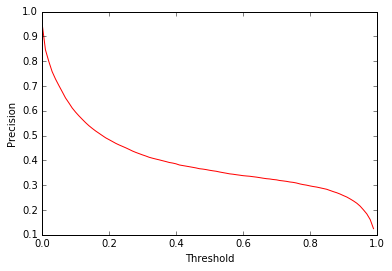

In [16]:
plt.plot(thresholds, precision, color='red')
plt.xlabel("Threshold")
plt.ylabel("Precision")

In [17]:
# Hits metric taking negative examples based on clustering into account
def hits_neg_threshold(predicted, probabilities, expected, expected_triples, other_index, threshold, cluster, all_pairs, verbose = 1):
    assert \
        len(predicted) == len(probabilities) and len(predicted) == len(expected), \
        "All inputs should have same length but got {}, {}, {}.".format(len(predicted), len(probabilities), len(expected))
    
    counts = []
    hits = []
    for i in range(len(predicted)):
        guess_indices = np.nonzero(probabilities[i] > threshold)
        guesses = predicted[i][guess_indices]
        is_hit = False
        has_miss = False
        
        # log the number of predictions
        counts.append(len(guesses))
                
        for g in guesses:
            if g == expected[i]:
                is_hit = True
            if is_negative(g, expected_triples[i][other_index[i]], cluster, all_pairs):
                has_miss = True
            if has_miss and is_hit:
                break
        
        if verbose > 1:
            print(i, expected_triples[i], 'hit:', is_hit, 'miss:', has_miss)
                 
        if is_hit:
            hits.append(1.0)
        else:
            hits.append(0.0)
            
        if has_miss:
            hits.append(0.0)
        else:
            hits.append(1.0)
    
    if verbose > 0:
        print(np.unique(hits, return_counts=True))
    
    return np.mean(hits), counts

In [18]:
thresholds = np.arange(0, 0.1, 0.01)
precisions = []
counts = []
times = []

for t in thresholds:
    begin = time.clock()
    precision, count = hits_neg_threshold(y_pred, y_prob, y_exp, triples_exp, other_exp, t, cluster, all_pairs)
    end = time.clock()
    precisions.append(precision)
    counts.append(count)
    times.append(end - begin)

(array([0., 1.]), array([10238,  9762]))
(array([0., 1.]), array([ 1620, 18380]))
(array([0., 1.]), array([ 2045, 17955]))
(array([0., 1.]), array([ 2442, 17558]))
(array([0., 1.]), array([ 2732, 17268]))
(array([0., 1.]), array([ 2984, 17016]))
(array([0., 1.]), array([ 3232, 16768]))
(array([0., 1.]), array([ 3485, 16515]))
(array([0., 1.]), array([ 3683, 16317]))
(array([0., 1.]), array([ 3890, 16110]))


In [19]:
np.mean(times)

0.2272195000000007

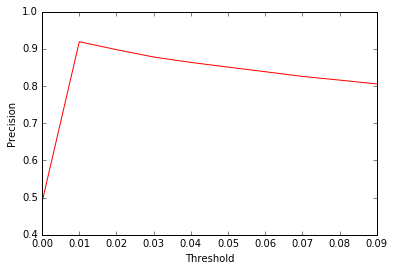

In [20]:
dims = 100
plt.plot(thresholds[:dims], precisions[:dims], color='red')
plt.xlabel("Threshold")
plt.ylabel("Precision")

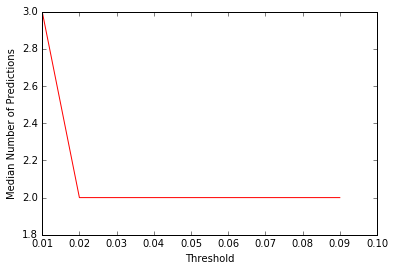

In [21]:
start = 1
plt.plot(thresholds[start:dims], np.median(counts, axis=1)[start:dims], color='red')
plt.xlabel("Threshold")
plt.ylabel("Median Number of Predictions")

In [22]:
def cluster_test_data(expected, predictions, probabilities):
    x = {}
    y = {}
    y_indices = {}

    i = 0
    for e in expected:
        key = (e[0][0], e[0][1])
        y_key = i

        if key not in x:
            x[key] = []  
            y[key] = (predictions[y_key], probabilities[y_key])
            y_indices[key] = []
            
        x[key].append(e[1][0])
        y_indices[key].append(y_key)
        i += 1

    return x, y, y_indices

In [23]:
# FastText Preprocesses the data so that every second triple has the head as label and the rest the tail respectively
tails = list(zip(triples_exp[1::2, :2].tolist(), triples_exp[1::2, 2:].tolist()))
heads = list(zip(triples_exp[::2, -1:0:-1].tolist(), triples_exp[::2, :1].tolist()))

In [24]:
x_tails, y_tails, keys = cluster_test_data(tails, y_pred[1::2], y_prob[1::2])
x_heads, y_heads, _ = cluster_test_data(heads, y_pred[::2], y_prob[::2])

In [25]:
# Check if we have selected the correct data
for k in keys:
    if len(keys[k]) > 1:
        print (triples_exp[(np.array(keys[k])*2 + 1).tolist()])
        break

[['01332730' '1__hyponym' '01233387']
 ['01332730' '1__hyponym' '01336159']]


In [26]:
# Hits metric that groups the data before evaluation and considers negative samples
def hits_batch_threshold(x, y, threshold, cluster, all_pairs, verbose=True):
    assert \
        len(y) == len(x), \
        "x and y should have same length but were {}, {}.".format(len(x), len(y))
    
    counts = []
    hits = []
    for k in x.keys():
        guess_indices = np.nonzero(y[k][1] > threshold)
        guesses = y[k][0][guess_indices]
        
        # log the number of predictions
        counts.append(len(guesses))
        
        for e in x[k]:
            if e in guesses:
                hits.append(1.0)
            else:
                hits.append(0.0)
        
        for g in guesses:
            if is_negative(g, k[0], cluster, all_pairs):
                hits.append(0.0)

# This is simply the hits@threshold as a validation:
#         for e in x[k]:
#             is_hit = np.any(y[k][1][np.nonzero(y[k][0] == e)] > threshold)

#             if is_hit:
#                 hits.append(1.0)
#             else:
#                 hits.append(0.0)
              
    if verbose:
        print(np.unique(hits, return_counts=True))
    return np.mean(hits), counts

In [27]:
# x = {(0, 1): [1, 2, 3], (0, 2): [], (1, 0): []}
# y = {(0, 1): (np.array([1, 2, 0, 3]),
#               np.array([0.9, 0.85, 0.4, 0.35])),
#      (0, 2): (np.array([1, 2]),
#               np.array([0.04, 0.01])),
#      (1, 0): (np.array([1]),
#               np.array([0.3]))}
# t = 0
# cluster = {0: 1, 1: 2, 2: 2, 3: 2}
# all_pairs = [(0, 1), (0, 2), (0, 3)]

In [28]:
# hits_batch_threshold(x, y, t, cluster, all_pairs, True)

In [29]:
thresholds = np.arange(0, 0.1, 0.001)
precisions = []
counts = []
times = []
x = {**x_heads, **x_tails}
y = {**y_heads, **y_tails}

for t in thresholds:
    begin = time.clock()
    precision, count = hits_batch_threshold(x, y, t, cluster, all_pairs, True)
    end = time.clock()
    precisions.append(precision)
    counts.append(count)
    times.append(end - begin)

(array([0., 1.]), array([473645,   9533]))
(array([0., 1.]), array([5128, 9282]))
(array([0., 1.]), array([2438, 9094]))
(array([0., 1.]), array([1883, 8917]))
(array([0., 1.]), array([1650, 8831]))
(array([0., 1.]), array([1587, 8771]))
(array([0., 1.]), array([1567, 8697]))
(array([0., 1.]), array([1577, 8641]))
(array([0., 1.]), array([1601, 8581]))
(array([0., 1.]), array([1624, 8526]))
(array([0., 1.]), array([1663, 8464]))
(array([0., 1.]), array([1705, 8404]))
(array([0., 1.]), array([1746, 8351]))
(array([0., 1.]), array([1792, 8299]))
(array([0., 1.]), array([1821, 8262]))
(array([0., 1.]), array([1856, 8224]))
(array([0., 1.]), array([1890, 8180]))
(array([0., 1.]), array([1929, 8133]))
(array([0., 1.]), array([1970, 8091]))
(array([0., 1.]), array([2017, 8039]))
(array([0., 1.]), array([2056, 7994]))
(array([0., 1.]), array([2093, 7952]))
(array([0., 1.]), array([2134, 7909]))
(array([0., 1.]), array([2169, 7869]))
(array([0., 1.]), array([2210, 7828]))
(array([0., 1.]), arr

In [30]:
np.mean(times)

0.16315925999999994

In [31]:
np.max(precisions)

0.8473304754481683

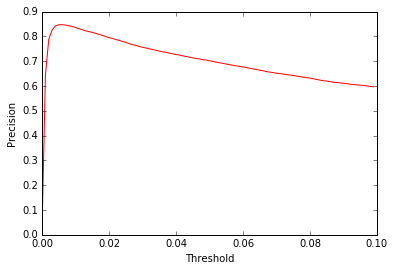

In [32]:
plt.plot(thresholds, precisions, color='red')
plt.xlabel("Threshold")
plt.ylabel("Precision")

In [34]:
## Becnhmark with approx. maximum
iterations = 10
threshold = 0.0011

times_group = []
times_neg = []

for i in range(iterations):
    start = time.clock()
    hits_batch_threshold(x, y, threshold, cluster, all_pairs, False)
    end = time.clock()
    times_group.append(end - start)
    
    start = time.clock()
    hits_neg_threshold(y_pred, y_prob, y_exp, triples_exp, other_exp, threshold, cluster, all_pairs, False)
    end = time.clock()
    times_neg.append(end - start)

print("Grouped:", np.mean(times_group), "Only Negatives:", np.mean(times_neg))

Grouped: 0.20346729999999907 Only Negatives: 0.3969346999999992


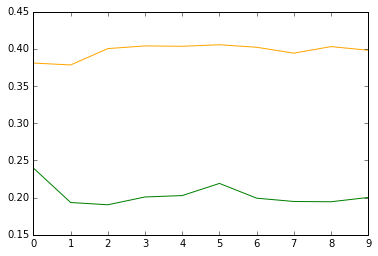

In [35]:
plt.plot(times_group, color='green')
plt.plot(times_neg, color='orange')
plt.show()

In [36]:
# TODO:
# Select negative samples from graph.
# Approaches:
# 1. Cluster the graph and select nodes pairs from to very different clusters – these should not appear in the data
# 2. Find nodes that never have an edge of some type

In [37]:
# Average probability among top 10
top_n = 10
top_prob = y_prob[:, :top_n]
np.median(top_prob), np.mean(top_prob), np.max(top_prob), np.min(top_prob)

(0.0030944550000000003, 0.08848193629022501, 1.00001, 1e-05)

In [38]:
y_prob.shape[1]

300

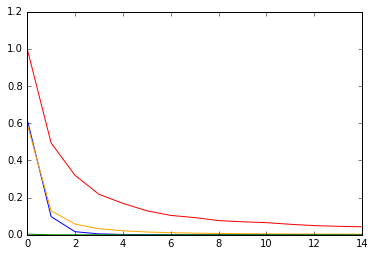

In [39]:
dims = 15
plt.plot(np.arange(dims), np.median(y_prob, axis=0)[:dims], color='blue')
plt.plot(np.arange(dims), np.mean(y_prob, axis=0)[:dims], color='orange')
plt.plot(np.arange(dims), np.max(y_prob, axis=0)[:dims], color='red')
plt.plot(np.arange(dims), np.min(y_prob, axis=0)[:dims], color='green')
plt.show()

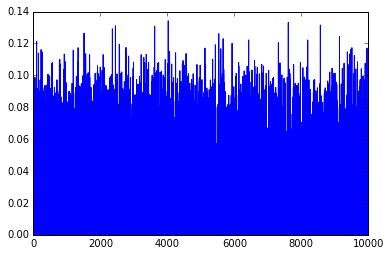

In [40]:
x = np.arange(len(top_prob))
plt.plot(x, np.median(top_prob, axis=1), color='blue')
#plt.plot(x, np.mean(top_prob, axis=1), color='orange')
#plt.plot(x, np.max(top_prob, axis=1), color='red')
#plt.plot(x, np.min(top_prob, axis=1), color='green')
plt.show()